# Base SVM Classifier Model for Malicious URL Analysis

In [1]:
import pandas as pd
import numpy as np

from sklearn import svm, preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, average_precision_score, precision_recall_curve, confusion_matrix, plot_roc_curve, roc_auc_score, classification_report

import feather
from joblib import dump, load
from pathlib import Path
import scikitplot as skplt
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from featureprocessing import LexicalFeatureProcessing as lfp
from datacleaning import URLDataCleaning as ucl

## Reading in Benign & Malicious datasets into Dataframe

In [2]:
df_benign = pd.read_csv('/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/Malicious-DS/URL/Benign_list_big_final.csv')
df_benign["URLType"] = "Benign"

df_malicious = pd.read_csv('/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/Malicious-DS/URL/Malware_dataset.csv')
df_malicious["URLType"] = "Malicious"

dfs = [df_benign, df_malicious]
df = pd.concat(dfs)
df.reset_index(drop=True, inplace=True)
df = df.sample(frac=1).reset_index(drop=True)

## Encode Binary URL Classifications
Here we are encoding the URLType binary classifications: "Benign" / "Malicious", using the LabelEncoder()<br/>
0 - Benign<br/>
1 - Malicious

In [3]:
enc = preprocessing.LabelEncoder()
df["URLType"] = enc.fit_transform(df.URLType.values)

## Extracting Lexical Features from Dataset

Here is where different lexical features are extracted from the full dataset (Features based on the vocabulary/makeup of the actual URL string itself).

In [4]:
feature_list = []
for index, row in df.iterrows():
    row["URL"] = ucl.clean_data(row["URL"])
    feature_dict = lfp.extract(row["URL"])
    feature_dict.update({"URLType": row["URLType"]})
    feature_list.append(feature_dict)

df_ft = pd.DataFrame(feature_list)

path = '/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/tmp/df_ft.feather'
try:
    open(path, 'x')
except FileExistsError:
    pass

feather.write_dataframe(df_ft, path)

In [5]:
new_df = feather.read_dataframe(path)
display(new_df)

,URLLength,HostLength,TLDLength,DotCount,DashCount,@Count,%Count,=Count,?Count,DigitCount,UniqueCharCount,URLType
0,105,9,0,2,14,0,0,0,0,19,31,0
1,102,10,0,2,12,0,0,0,0,19,34,0
2,97,9,0,2,12,0,0,0,0,21,27,0
3,95,15,0,1,10,0,0,0,0,5,30,0
4,87,11,0,2,13,0,0,0,0,6,27,0
...,...,...,...,...,...,...,...,...,...,...,...,...
46939,96,7,0,2,4,0,0,1,1,24,31,0
46940,99,14,0,1,9,0,0,0,0,9,30,0
46941,107,13,0,1,8,0,0,0,0,41,34,0
46942,100,10,0,1,10,0,0,0,0,6,29,0


In [6]:
x = df_ft.drop('URLType', axis=1)
y = df_ft["URLType"]

display(x)

x_scaled = preprocessing.scale(x)

X_train, x_test, Y_train, y_test = train_test_split(x_scaled, y, test_size = 0.2, random_state = 0)

,URLLength,HostLength,TLDLength,DotCount,DashCount,@Count,%Count,=Count,?Count,DigitCount,UniqueCharCount
0,105,9,0,2,14,0,0,0,0,19,31
1,102,10,0,2,12,0,0,0,0,19,34
2,97,9,0,2,12,0,0,0,0,21,27
3,95,15,0,1,10,0,0,0,0,5,30
4,87,11,0,2,13,0,0,0,0,6,27
...,...,...,...,...,...,...,...,...,...,...,...
46939,96,7,0,2,4,0,0,1,1,24,31
46940,99,14,0,1,9,0,0,0,0,9,30
46941,107,13,0,1,8,0,0,0,0,41,34
46942,100,10,0,1,10,0,0,0,0,6,29


In [7]:
clf = SVC(gamma='auto')
clf.fit(X_train, Y_train)

y_pred = clf.predict(x_test)
accuracy_score(y_test, y_pred)

0.9651720097987007

In [8]:
y_score = clf.decision_function(x_test)

In [9]:
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.97


[[7014  103]
 [ 224 2048]]


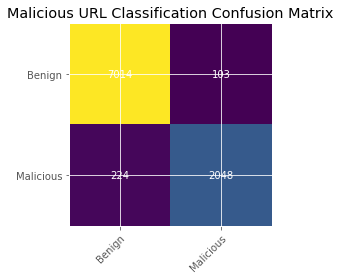

In [10]:
class_names = ['Benign', 'Malicious']

cm = confusion_matrix(y_test, y_pred)
print(cm)

fig, ax = plt.subplots()
im = ax.imshow(cm)

# We want to show all ticks...
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
# ... and label them with the respective list entries
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Malicious URL Classification Confusion Matrix")
fig.tight_layout()
plt.show()

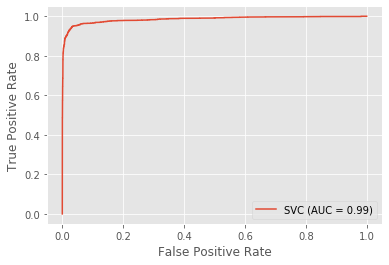

In [11]:
svc_disp = plot_roc_curve(clf, x_test, y_test)
plt.show()

In [12]:
print(roc_auc_score(y_test, y_score))

0.9850333250380461


In [53]:
dump(clf, 'models/base_estim.joblib')

['models/base_estim.joblib']